In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model, losses
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time  # Add time module
from tensorflow.keras.preprocessing.image import smart_resize

# Define the weighted VAE loss function
def vae_loss(inputs, outputs, mu, log_var):
    reconstruction_loss = tf.reduce_mean(losses.binary_crossentropy(inputs, outputs))
    kl_loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
    return reconstruction_loss + 0.25 * kl_loss  # Weight reconstruction more heavily
    
def build_vae(input_shape):
    # Encoder
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Flatten()(x)
    
    mu = layers.Dense(128)(x)
    log_var = layers.Dense(128)(x)

    # Sampling function
    def sampling(args):
        mu, log_var = args
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mu + tf.exp(0.5 * log_var) * epsilon

    z = layers.Lambda(sampling)([mu, log_var])

    # Decoder
    decoder_input = layers.Input(shape=(128,))
    x = layers.Dense(64 * 64 * 128, activation='relu')(decoder_input)
    x = layers.Reshape((64, 64, 128))(x)
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    outputs = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

    encoder = Model(inputs, [z, mu, log_var], name='encoder')
    decoder = Model(decoder_input, outputs, name='decoder')

    vae_outputs = decoder(encoder(inputs)[0])
    vae = Model(inputs, vae_outputs, name='vae')

    # Add loss function
    vae.add_loss(vae_loss(inputs, vae_outputs, encoder(inputs)[1], encoder(inputs)[2]))
    vae.compile(optimizer='adam')

    return vae, encoder, decoder


C:\Users\priya\anaconda3\envs\anacondagpu\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


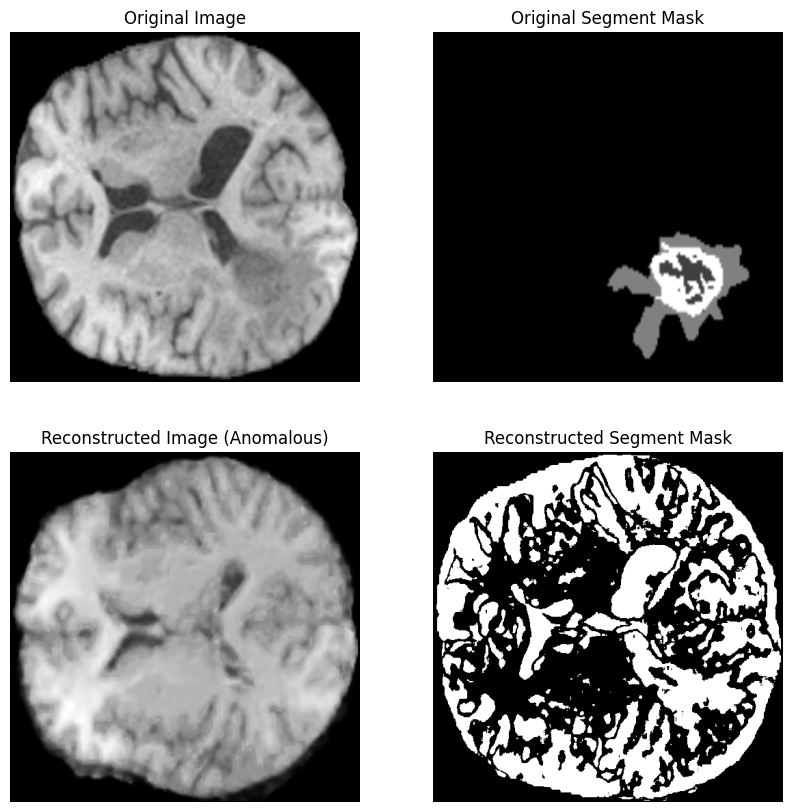

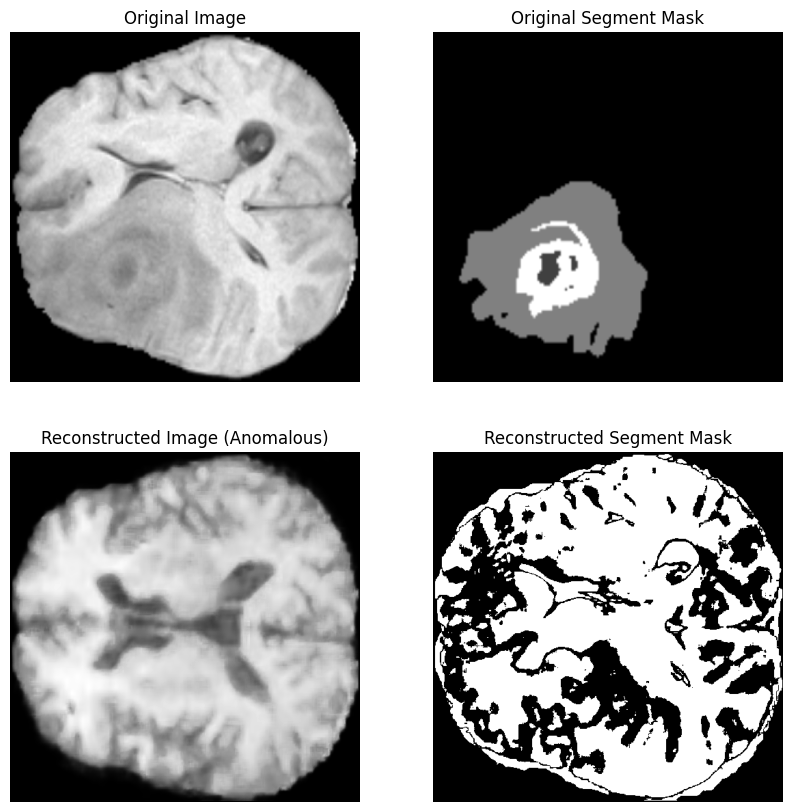

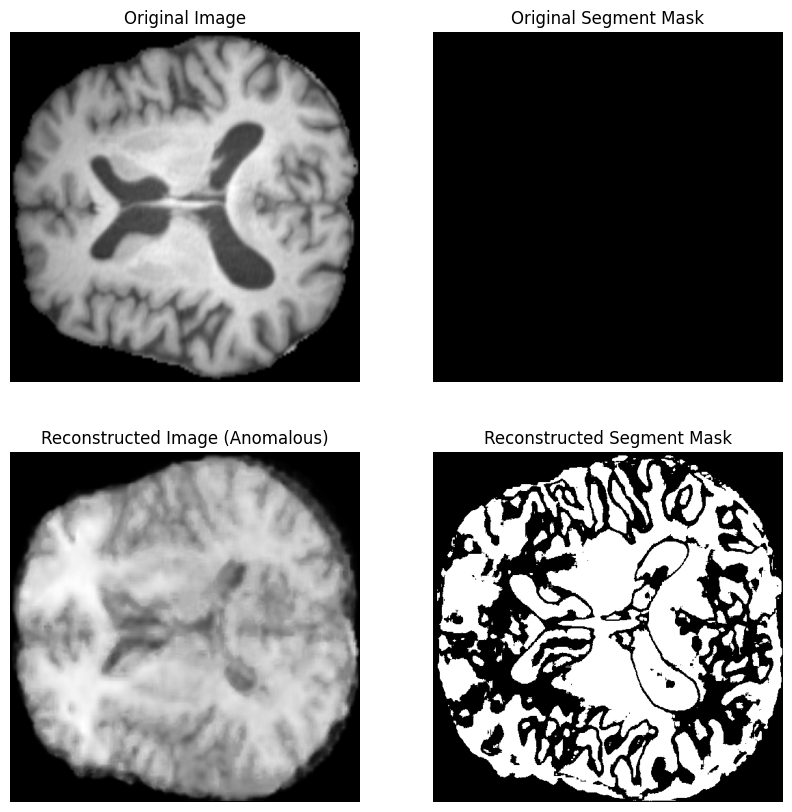

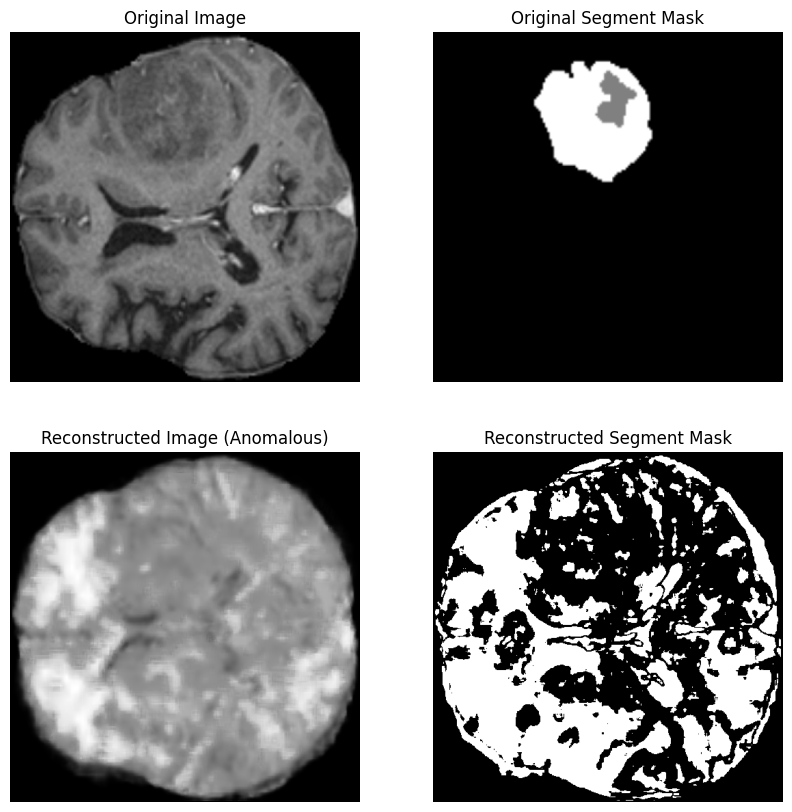

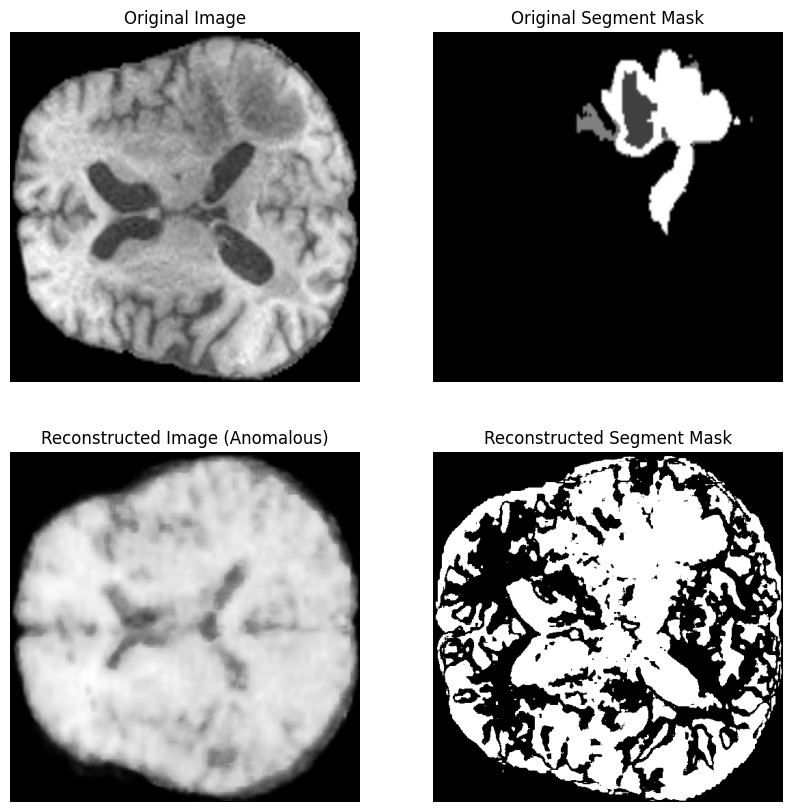

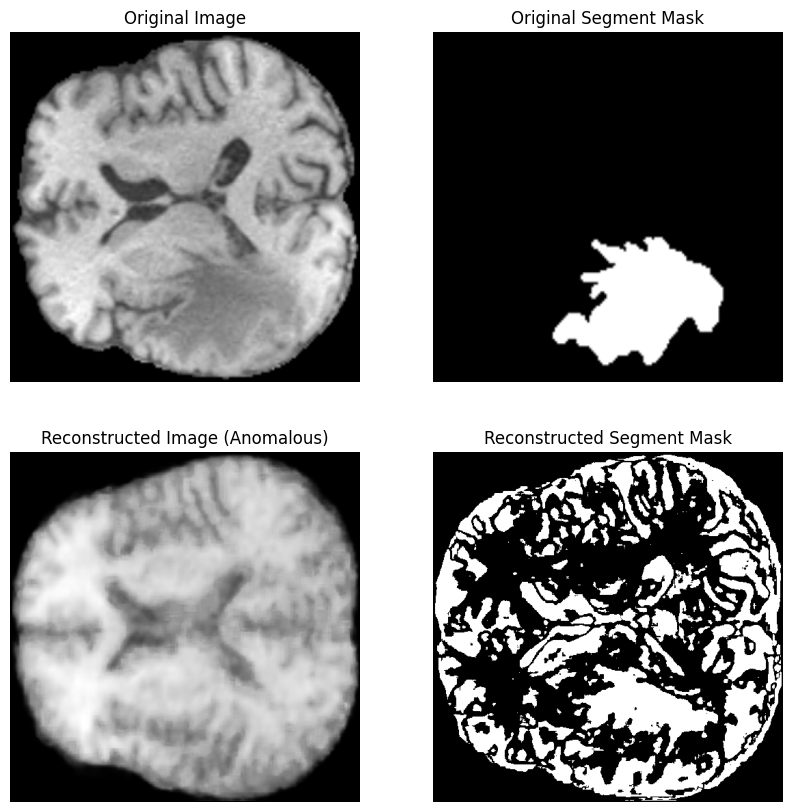

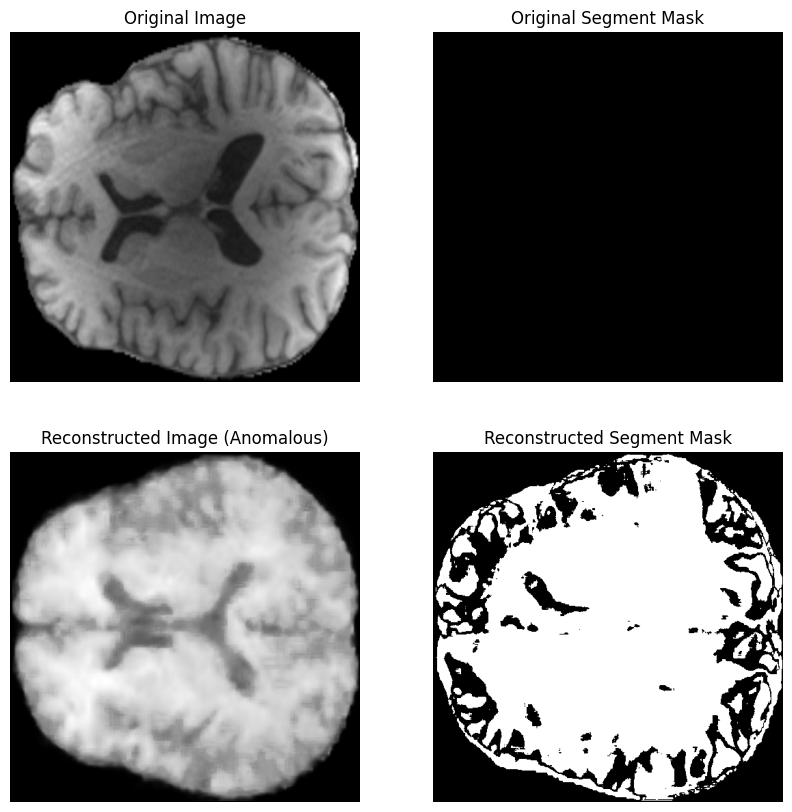

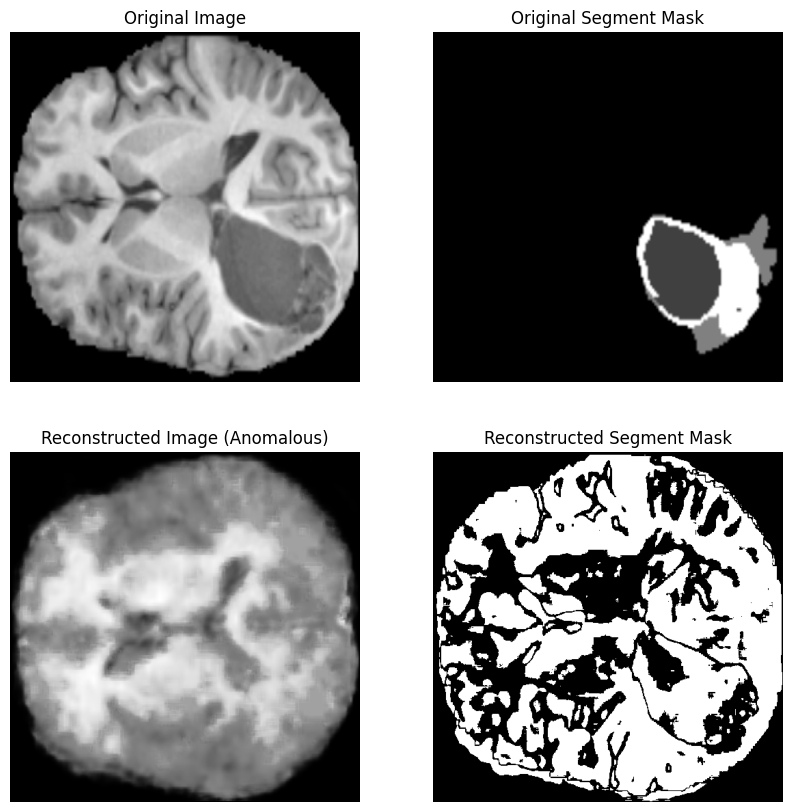

Precision: 0.75
Recall: 1.0
F1-Score: 0.8571428571428571
ROC-AUC: 0.3333333333333333
Jaccard Score (IoU): 0.75


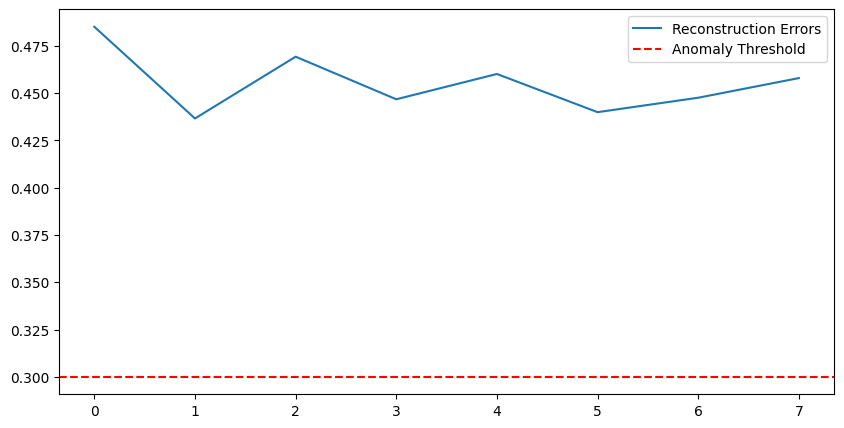

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, jaccard_score
from skimage.metrics import structural_similarity as ssim
import os

from skimage.metrics import structural_similarity as ssim

# Function to calculate reconstruction error using SSIM
def calculate_reconstruction_error(original, reconstructed):
    ssim_error = []
    for orig_img, recon_img in zip(original, reconstructed):
        orig_img = np.squeeze(orig_img)  # Remove channel/batch dimensions
        recon_img = np.squeeze(recon_img)
        # Calculate SSIM and subtract from 1 for error
        ssim_index, _ = ssim(orig_img, recon_img, data_range=1.0, full=True)
        ssim_error.append(1 - ssim_index)  # Error is the difference from perfect similarity
    return np.array(ssim_error)


# Function to classify as anomalous based on a threshold
def classify_anomalies(reconstruction_error, threshold):
    return reconstruction_error > threshold

# Load test images and masks from directory, and set true labels based on mask content
def load_images_and_labels_from_folder(folder_path):
    brain_images = []
    segment_masks = []
    true_labels = []
    
    image_files = sorted([f for f in os.listdir(folder_path) if f.endswith("_processed_image.png")])
    mask_files = sorted([f for f in os.listdir(folder_path) if f.endswith("_processed_mask.png")])
    
    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(folder_path, img_file)
        mask_path = os.path.join(folder_path, mask_file)
        
        # Load image and mask
        image = load_image(img_path)
        mask = load_image(mask_path)
        
        brain_images.append(image)
        segment_masks.append(mask)
        
        # Check if mask is completely black (normal case)
        if np.all(mask == 0):
            true_labels.append(0)  # Normal
        else:
            true_labels.append(1)  # Anomalous
            
    return brain_images, segment_masks, true_labels

# Load single image and normalize
def load_image(img_path):
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (512, 512))
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    image = image / 255.0  # Normalize
    return np.expand_dims(image, axis=0)  # Add batch dimension

# Define a function to evaluate model performance and show reconstructed images
def evaluate_model_and_display(vae, test_images, test_masks, true_labels, threshold):
    reconstruction_errors = []
    predictions = []
    
    for img, mask in zip(test_images, test_masks):
        original = img
        original_mask = mask
        reconstructed = vae.predict(img)  # Predict reconstructed image
        
        # Calculate reconstruction error using SSIM
        error = calculate_reconstruction_error(original, reconstructed)
        reconstruction_errors.append(error)
        
        # Determine if the image is anomalous
        anomaly_prediction = classify_anomalies(error, threshold)
        predictions.append(anomaly_prediction)
        
        # Generate reconstructed segment mask by thresholding the difference between original and reconstructed images
        reconstructed_mask = np.abs(original - reconstructed) > 0.1  # Adjust threshold as needed
        
        # Display original image, segment mask, reconstructed image, and reconstructed segment mask
        plt.figure(figsize=(10, 10))
        
        # Original image
        plt.subplot(2, 2, 1)
        plt.imshow(np.squeeze(original), cmap='gray')
        plt.title("Original Image")
        plt.axis("off")

        # Original segment mask
        plt.subplot(2, 2, 2)
        plt.imshow(np.squeeze(original_mask), cmap='gray')
        plt.title("Original Segment Mask")
        plt.axis("off")
        
        # Reconstructed image
        plt.subplot(2, 2, 3)
        plt.imshow(np.squeeze(reconstructed), cmap='gray')
        plt.title("Reconstructed Image" + (" (Anomalous)" if anomaly_prediction else " (Normal)"))
        plt.axis("off")

        # Reconstructed segment mask
        plt.subplot(2, 2, 4)
        plt.imshow(np.squeeze(reconstructed_mask), cmap='gray')
        plt.title("Reconstructed Segment Mask")
        plt.axis("off")
        
        plt.show()
    
    # Convert reconstruction_errors and predictions to arrays
    reconstruction_errors = np.array(reconstruction_errors).flatten()
    predictions = np.array(predictions).flatten()
    
    # Calculate evaluation metrics
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    roc_auc = roc_auc_score(true_labels, reconstruction_errors)
    
    # Compare the reconstructed mask and original mask for additional metrics
    jaccard = jaccard_score(true_labels, predictions, average="binary")
    
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print(f"ROC-AUC: {roc_auc}")
    print(f"Jaccard Score (IoU): {jaccard}")

    return predictions, reconstruction_errors

# Example usage
folder_path = "test_cropped"  # Path to the folder containing test images and masks
test_images, test_masks, true_labels = load_images_and_labels_from_folder(folder_path)

# Load the saved VAE model
vae, encoder, decoder = build_vae(input_shape=(512, 512, 1))
vae.load_weights("vae_model_epoch_2000.h5")  # Replace with the correct path

# Set an anomaly threshold
anomaly_threshold = 0.3  # Tune this based on validation results

# Evaluate the model and display reconstructed images and masks
predictions, reconstruction_errors = evaluate_model_and_display(vae, test_images, test_masks, true_labels, anomaly_threshold)

# Plot the reconstruction errors
plt.figure(figsize=(10, 5))
plt.plot(reconstruction_errors, label="Reconstruction Errors")
plt.axhline(y=anomaly_threshold, color='r', linestyle='--', label="Anomaly Threshold")
plt.legend()
plt.show()
